#Imports

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA

#Loading DataSets

In [58]:
url = "https://raw.githubusercontent.com/SaikotCSE/ml_lab/main/Heart_Disease_Prediction.csv"
df = pd.read_csv(url)

df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


#Basic Inspection

In [59]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

,0
Age,0
Sex,0
Chest pain type,0
BP,0
Cholesterol,0
FBS over 120,0
EKG results,0
Max HR,0
Exercise angina,0
ST depression,0


#Preprocessing

In [60]:
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

X = X.fillna(X.mean())

#Feature Scaling


In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train / Validation / Test Split

In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

#Elbow Method (Error Rate vs K)

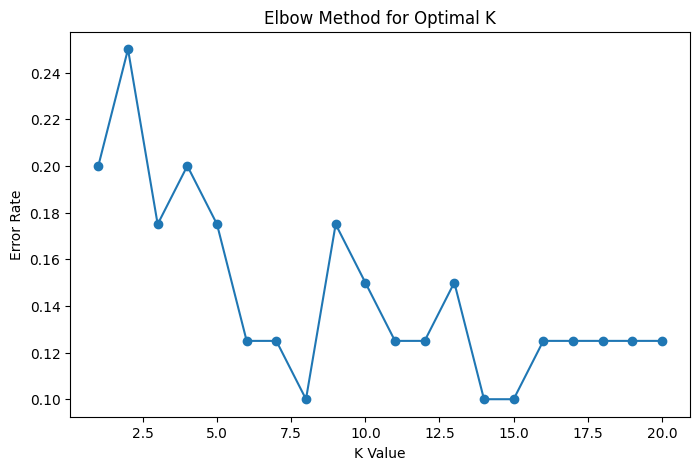

In [63]:
error_rate = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_val)
    error_rate.append(np.mean(pred != y_val))

plt.figure(figsize=(8,5))
plt.plot(range(1,21), error_rate, marker='o')
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.title("Elbow Method for Optimal K")
plt.show()

#Hyperparameter Tuning (GridSearchCV)


In [64]:
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}


#Train Final KNN Model

In [65]:
best_knn = grid.best_estimator_
best_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=4)

#Model Evaluation

In [66]:
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1]

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Presence')
recall    = recall_score(y_test, y_pred, pos_label='Presence')
f1        = f1_score(y_test, y_pred, pos_label='Presence')
auc       = roc_auc_score(y_test, y_prob)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

Accuracy:  0.8537
Precision: 0.8750
Recall:    0.7778
F1-score:  0.8235
AUC:       0.8732


#Confusion Matrix (Heatmap)

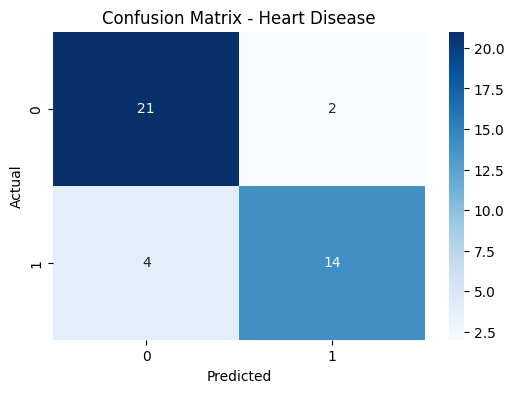

In [67]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Heart Disease")
plt.show()

#ROC Curve

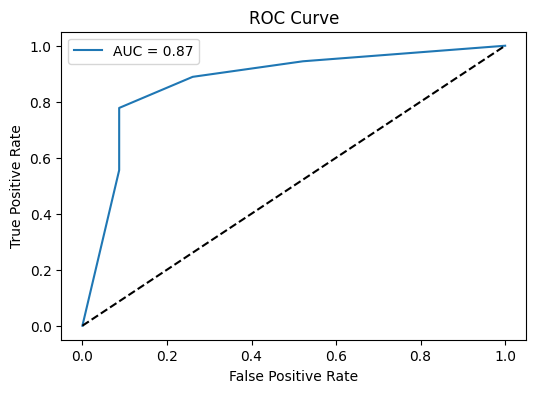

In [68]:
from sklearn.preprocessing import LabelEncoder
if y_test.dtype == 'object':
    y_test = LabelEncoder().fit_transform(y_test)

y_prob = best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#2D Decision Boundary

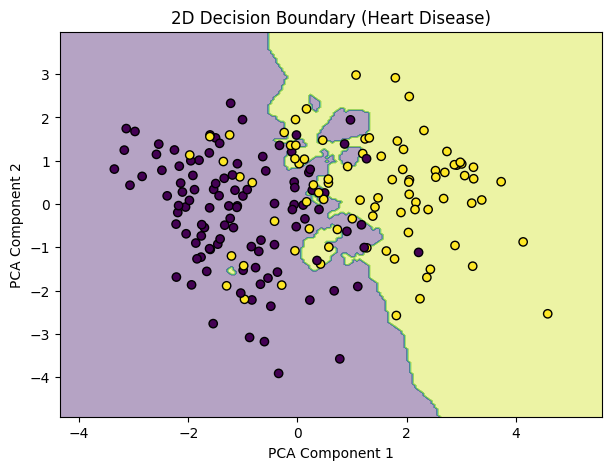

In [69]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

knn_2d = KNeighborsClassifier(
    n_neighbors=grid.best_params_['n_neighbors']
)
knn_2d.fit(X_pca, y_train_enc)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.astype(int)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_train_enc,
    edgecolor='k'
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Decision Boundary (Heart Disease)")
plt.show()